<a href="https://colab.research.google.com/github/nhuang37/double_descent/blob/teresa/hat_matrix_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/JHU/NIPS/double_descent/
!pip install -e .

/content/drive/My Drive/JHU/NIPS/double_descent
Obtaining file:///content/drive/My%20Drive/JHU/NIPS/double_descent
  Attempting uninstall: partition-decode
    Found existing installation: partition-decode 0.0.1
    Can't uninstall 'partition-decode'. No files were found to uninstall.
  Running setup.py develop for partition-decode


In [3]:
import numpy as np
from partition_decode.dataset import generate_gaussian_parity, load_mnist
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from partition_decode.df_utils import (
    get_tree_evals,
    get_forest_evals,
    get_forest_irm,
    get_tree_irm,
)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, zero_one_loss
from scipy.linalg import block_diag

In [4]:
# define gaussian kernel for kernel weighted knn
def gaussian_kernel(distances, kernel_width = 2):
    #we shall tune kernel_width later: classifier (width = 2)
    weights = np.exp(-(distances**2)/kernel_width)
    return weights

In [5]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
#ref: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html
#hat{y} = \sum_ I_{X_i \in knn(X)} W_i Y_i

def run_knn(X_train, y_train, X_test, k, KNmodel, mode='distance'):
    '''
    Run knn experiments
    mode: 'connectivity' corresponds to 'uniform weight'
    irm: compute for testdata (train_time: diag(1/k) for 'uniform'; identity for 'distance')
    prediction: y_pred = (hat_matrix \odot y_train[neighbors]).sum(axis=1)
    '''
    if mode == 'distance':
      model = KNmodel(n_neighbors=k, weights='distance')
    else:
      model = KNmodel(n_neighbors=k, weights='uniform')
    #print(weight_mode)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    graph_dist = model.kneighbors_graph(X_test, mode=mode).toarray() #TEST TIME! n by n 
    #divide when setting 0/0 = 0
    with np.errstate(divide='ignore', invalid='ignore'):
      weights = np.true_divide(1,graph_dist)
      weights[weights == np.inf] = 0
      weights = np.nan_to_num(weights) 
    #normalize weights to have row sum as 1
    denom = np.sum(weights, axis=1, keepdims=1)
    hat_matrix = weights/denom
    irm = (hat_matrix!=0).astype(int)
    return y_train_pred, y_test_pred, hat_matrix, irm

In [6]:
X_train, y_train = generate_gaussian_parity(
    n_samples=100, angle_params=0, random_state=1, cov_scale=1.0
)
X_test, y_test = generate_gaussian_parity(
    n_samples=1024, angle_params=0, random_state=1234, cov_scale=1.0
)


In [7]:
#classifier, by distance
%%time
results = {}
model = KNeighborsRegressor#KNeighborsClassifier
n = X_train.shape[0]
ks = np.arange(1,n+1)
modes = ['distance'] #'connectivity'
for mode in modes:
  gen_errors = []
  irms = []
  hats = []
  train_errors = []
  test_errors = []
  for k in ks:
      y_train_hat, y_test_hat, hat_matrix, irm = run_knn(X_train, y_train, X_test, k, model, mode=mode)  
      train_errors.append(mean_squared_error(y_train, y_train_hat))
      test_errors.append(mean_squared_error(y_test, y_test_hat))
      gen_errors.append(test_errors[-1] - train_errors[-1])
      hats.append(hat_matrix)
      irms.append(irm)
  results[mode] = (train_errors, test_errors, gen_errors, hats, irms)


CPU times: user 2.37 s, sys: 1.33 s, total: 3.7 s
Wall time: 3.22 s


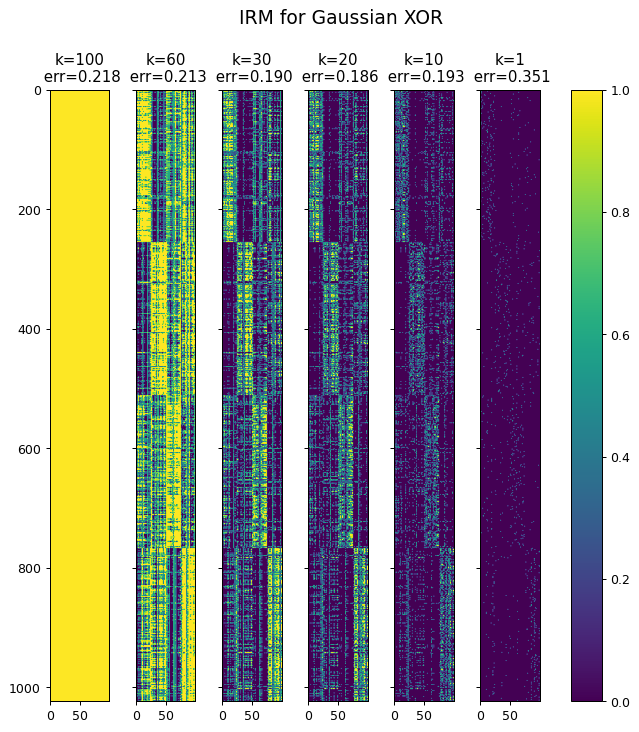

In [8]:
fig, axs = plt.subplots(sharex=True, sharey=True, ncols=6, figsize=(9,9), dpi=90)
for plot_i, idx in enumerate([100,60,30,20,10,1]):
    err = results['distance'][1][idx-1]
    im = axs[plot_i].imshow(results['distance'][-1][idx-1], vmin=0, vmax=1)
    axs[plot_i].set_title(f'k={idx}\n err={err:.3f}')
fig.colorbar(im, ax=axs.ravel().tolist())
fig.suptitle(r"IRM for Gaussian XOR", fontsize=15)
plt.show()
    #break

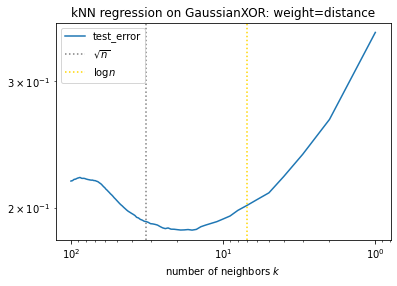

In [9]:
plt.plot(ks, gen_errors, label='test_error')
plt.axvline(np.sqrt(1024), ls=':', c='grey', label=r'$\sqrt{n}$')
plt.axvline(np.log(1024), ls=':', c='gold', label=r'$\log{n}$')
plt.loglog()
plt.gca().invert_xaxis()
plt.legend()
plt.title('kNN regression on GaussianXOR: weight=distance')
plt.xlabel(r'number of neighbors $k$')
plt.ylabel(r'')
plt.show()

In [10]:
# MISC: tune gaussian width custom weight function (no significant change in test loss)
# test_errors_5 = []
# for width in [1,5,20,100]:
#   def gaussian_kernel(distances):
#     kernel_width = width
#     weights = np.exp(-(distances**2)/kernel_width)
#     return weights
#   model = KNeighborsRegressor(n_neighbors=5, weights=gaussian_kernel)
#   #print(weight_mode)
#   model.fit(X_train, y_train)
#   y_train_pred = model.predict(X_train)
#   y_test_pred = model.predict(X_test)
#   test_errors_5.append(mean_squared_error(y_test, y_test_pred))